In [1]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
import requests
import re
import Levenshtein
import itertools
from fuzzywuzzy import fuzz
import fasttext
from sklearn.metrics.pairwise import cosine_similarity
from fastDamerauLevenshtein import damerauLevenshtein

TODO: use mapping between cities from examples dataset

In [2]:
partner1_df = pd.read_excel("Example.xlsx", "Partner1")
partner2_df = pd.read_excel("Example.xlsx", "Partner2")
examples_df = pd.read_excel("Example.xlsx", "examples")

# rename columns 
partner1_df.columns = ['key', 'hotel_name', 'city_name', 'country_code','hotel_address', 'star_rating', 'postal_code']
partner2_df.columns = ['key', 'hotel_name', 'city_name', 'country_code','hotel_address', 'star_rating', 'postal_code']

examples_df.shape

(499, 14)

In [3]:
# check for missing values
partner1_df.isna().sum(), partner2_df.isna().sum()

(key                 0
 hotel_name          0
 city_name           0
 country_code        5
 hotel_address       1
 star_rating         0
 postal_code      1750
 dtype: int64,
 key                0
 hotel_name         0
 city_name          0
 country_code       5
 hotel_address      1
 star_rating        0
 postal_code      664
 dtype: int64)

since only a few "country_code" are missing, it really doesn't make any sense to fill them. but if we want to try to fill them I thought about using the known mapping between city - country_code. (the commented code) 

In [ ]:
# # check if can infer country based on city
# all_known_countries_and_cities_df = pd.concat([partner1_df.loc[:,['city_name', 'country_code']],
#                                               partner2_df.loc[:,['p2.city_name', 'p2.country_code']],
#                                               examples_df.loc[:,['p1.city_name', 'p1.country_code']].rename(columns={'p1.city_name': 'city_name', 'p1.country_code': 'country_code'}),
#                                               examples_df.loc[:,['p2.city_name', 'p2.country_code']].rename(columns={'p2.city_name': 'city_name', 'p2.country_code': 'country_code'})])
# unique_countries_per_city = all_known_countries_and_cities_df.groupby('city_name')['country_code'].apply(lambda x: np.unique(x))


# # try to fill "country_code" nans using city name --DOESNT REALLY WORK since cities are new to us
# partner1_df['p1.country_code1'] = partner1_df.apply(
#     lambda row: unique_countries_per_city.loc[row['p1.city_name']][0] if len(unique_countries_per_city.loc[row['p1.city_name']]) == 1 else row['p1.country_code'], axis=1)

I don't see anything interesting to learn in star_rating, although maybe we can check by spliting into countries to learn a new relation???

<AxesSubplot:>

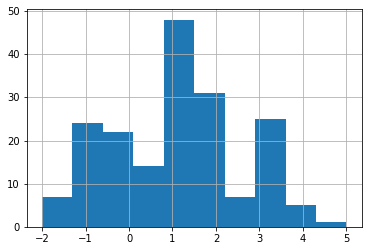

In [4]:
# judging by examples_df - star_rating is not super reliable
star_rating_df = examples_df.loc[examples_df['p1.star_rating'] != examples_df['p2.star_rating']].loc[:,['p1.star_rating', "p2.star_rating", "p1.country_code"]]
star_rating_df = star_rating_df.dropna()
star_rating_df["diff_rating"] = star_rating_df["p1.star_rating"] - star_rating_df["p2.star_rating"]
star_rating_df["diff_rating"].hist()

In [890]:
#star_rating_df.groupby('p1.country_code').diff_rating.apply(lambda x: x.unique())

found a website online with mapping between country code and name. will use to strip country name from address/ hotel name

In [5]:
page = requests.get("https://www.iban.com/country-codes")
soup = BeautifulSoup(page.content, 'html.parser')

#country_name, country_id = [], []
country2id = {}
for tr in soup.find_all('tr')[2:]:
    tds = tr.find_all('td')
    #country_name.append(tds[0].text) 
    #country_id.append(tds[1].text)
    country2id[tds[1].text] = tds[0].text
    
country2id['XK'] = 'Kosovo'
country2id['LA'] = 'laos'
    
#country2id = pd.DataFrame.from_dict({"country_name": country_name, "country_id": country_id})
#country2id.head()

# check that "country_id" is a unique identifier
print(len(np.unique(list(country2id.values())))/len(country2id.values()))

1.0


In [6]:
# check if all addresses are strings
partner1_df['hotel_address'].loc[partner1_df['hotel_address'].apply(type) != type(partner1_df['hotel_address'][0])]

818                     NaN
996                    2117
2324                   2505
2341    2008-02-02 00:00:00
3014    2029-02-07 00:00:00
3449                    171
3537                   4169
5270                   4027
7079                    300
8234    2001-01-05 00:00:00
8406    2016-02-18 00:00:00
9301    2012-02-12 00:00:00
Name: hotel_address, dtype: object

In [7]:
# some addresses are actually dates so just convert to na 
import time
def isTimeFormat(s):
    try:
        time.strptime(str(s), '%Y-%m-%d %H:%M:%S')
        return ''
    except:
        return str(s)
partner1_df['hotel_address'] = partner1_df['hotel_address'].apply(isTimeFormat)
partner2_df['hotel_address'] = partner2_df['hotel_address'].apply(isTimeFormat)

In [8]:
# lowercase 
examples_df['p1.city_name'] = examples_df['p1.city_name'].str.lower()
examples_df['p2.city_name'] = examples_df['p2.city_name'].str.lower()
examples_df['p1.hotel_address'] = examples_df['p1.hotel_address'].str.lower()
examples_df['p2.hotel_address'] = examples_df['p2.hotel_address'].str.lower()

partner1_df['hotel_address'] = partner1_df['hotel_address'].str.lower()
partner2_df['hotel_address'] = partner2_df['hotel_address'].str.lower()
partner1_df['city_name'] = partner1_df['city_name'].str.lower()
partner2_df['city_name'] = partner2_df['city_name'].str.lower()
partner1_df['hotel_name'] = partner1_df['hotel_name'].str.lower()
partner2_df['hotel_name'] = partner2_df['hotel_name'].str.lower()

# check if our dataset "country_id" matches all with scraped "country_id"s
partner1_df['country_name'] = partner1_df['country_code'].apply(lambda c: country2id[c].lower() if not pd.isnull(c) else c)
partner2_df['country_name'] = partner2_df['country_code'].apply(lambda c: country2id[c].lower() if not pd.isnull(c) else c)

examples_df['p1.country_name'] = examples_df['p1.country_code'].apply(lambda c: country2id[c].lower() if not pd.isnull(c) else c)
examples_df['p2.country_name'] = examples_df['p2.country_code'].apply(lambda c: country2id[c].lower() if not pd.isnull(c) else c)


#partner1_df['p1.country_code'] = partner1_df['p1.country_code'].apply(str)

# remove "-" or spaces from postal_code string
partner1_df['clean_postal_code'] = partner1_df['postal_code'].apply(lambda s: list(filter(len, re.split('-| ',str(s)))))
partner2_df['clean_postal_code'] = partner2_df['postal_code'].apply(lambda s: list(filter(len, re.split('-| ',str(s)))))
examples_df['p1.clean_postal_code'] = examples_df['p1.postal_code'].apply(lambda s: list(filter(len, re.split('-| ',str(s)))))
examples_df['p2.clean_postal_code'] = examples_df['p2.postal_code'].apply(lambda s: list(filter(len, re.split('-| ',str(s)))))

In [9]:
partner1_df.fillna('', inplace=True)
partner2_df.fillna('', inplace=True)
examples_df.fillna('', inplace=True)

In [99]:
#list(partner1_df.loc[partner1_df['postal_code'].apply(type) != partner1_df['postal_code'].apply(type)[0]]['postal_code'].unique())

In [10]:
# lets remove all mentions of cities/ country id's from addresses and hotel names:
all_cities = partner1_df['city_name'].apply(
    lambda s: [part.strip() for part in re.split('[\(\)]', s) if part.strip()]).tolist() + partner2_df['city_name'].apply(
    lambda s: [part.strip() for part in re.split('[\(\)]', s) if part.strip()]).tolist() + examples_df['p1.city_name'].apply(
    lambda s: [part.strip() for part in re.split('[\(\)]', s) if part.strip()]).tolist() + examples_df['p2.city_name'].apply(
    lambda s: [part.strip() for part in re.split('[\(\)]', s) if part.strip()]).tolist()
    
all_cities = [re.sub(r'[^\w\s]',' ',str(c)) for c_l in all_cities for c in c_l]

all_countries = partner1_df['country_code'].apply(
    lambda s: s.split()).tolist() +partner2_df['country_code'].apply(
    lambda s: s.split()).tolist() + examples_df['p1.country_code'].apply(
    lambda s: s.split()).tolist() + examples_df['p2.country_code'].apply(
    lambda s: s.split()).tolist()
all_countries = [re.sub(r'[^\w\s]',' ',str(c)) for c_l in all_countries for c in c_l ]


countries_and_cities_unique = list(np.unique(all_cities + all_countries))
countries_and_cities_unique = [c for c in countries_and_cities_unique if len(c)>1]
len(countries_and_cities_unique)

4554

In [11]:
import pdb
def remove_from_string(input_string: str, words_to_remove: list):
    try:
        input_string = re.sub(r'[^\w\s]',' ',str(input_string))
        input_string_words = input_string.split()
    except:
        pdb.set_trace()
    return ' '.join([word.lower() for word in input_string_words if word.lower() not in words_to_remove])

# remove city and country name from address
address_redundent_words = ['dr', 'drive', 'city', 'street', 'st', 'str', 'streets', 'road', 'blvd', 'roads', 'rd', 'district', 'boulevard', 'via']

partner1_df['clean_address'] = partner1_df.apply(
    lambda row: remove_from_string(row['hotel_address'], 
                                   address_redundent_words + countries_and_cities_unique), axis=1)

partner2_df['clean_address'] = partner2_df.apply(
    lambda row: remove_from_string(row['hotel_address'], 
                                   address_redundent_words + countries_and_cities_unique), axis=1)

examples_df['p1.clean_address'] = examples_df.apply(
    lambda row: remove_from_string(row['p1.hotel_address'], 
                                   address_redundent_words + countries_and_cities_unique), axis=1)

examples_df['p2.clean_address'] = examples_df.apply(
    lambda row: remove_from_string(row['p2.hotel_address'], 
                                   address_redundent_words + countries_and_cities_unique), axis=1)

In [12]:
# list of known easy keywords from "hotel_name" - NOT USED!
hotel_name_redundent_words = ['hostel', 'guesthouse','resort', 'resorts', 'suites', 'suite', 'apartment', 'apartments', 'inn', 'hotel', 'hotels', 'and', '&']

# remove city and country name and keywords from "hotel_name":
partner1_df['clean_hotel_name'] = partner1_df.apply(
    lambda row: remove_from_string(row['hotel_name'], 
                                   countries_and_cities_unique), axis=1)

partner2_df['clean_hotel_name'] = partner2_df.apply(
    lambda row: remove_from_string(row['hotel_name'], 
                                   countries_and_cities_unique), axis=1)

examples_df['p1.clean_hotel_name'] = examples_df.apply(
    lambda row: remove_from_string(row['p1.hotel_name'], 
                                   countries_and_cities_unique), axis=1)

examples_df['p2.clean_hotel_name'] = examples_df.apply(
    lambda row: remove_from_string(row['p2.hotel_name'], 
                                   countries_and_cities_unique), axis=1)


from difflib import SequenceMatcher
def remove_longest_substring_from_first(s1, s2):
    match = SequenceMatcher(None, s1, s2).find_longest_match()
    matched_str = s1[match.a:match.a + match.size]
    matched_str = " ".join(m for m in matched_str.split() if m in s1.split() or m in s2.split())
    if len(matched_str) > 3:
    # return s1[:match.a]+ s1[match.a + match.size:]
        return s1.replace(matched_str, "").strip()
    return s1



# remove address from hotel name:
partner1_df['clean_hotel_name'] = partner1_df.apply(
    lambda row: remove_longest_substring_from_first(row['clean_hotel_name'], row['clean_address']), axis=1)

partner2_df['clean_hotel_name'] = partner2_df.apply(
    lambda row: remove_longest_substring_from_first(row['clean_hotel_name'], row['clean_address']), axis=1)

examples_df['p1.clean_hotel_name'] = examples_df.apply(
    lambda row: remove_longest_substring_from_first(row['p1.clean_hotel_name'], row['p1.clean_address']), axis=1)

examples_df['p2.clean_hotel_name'] = examples_df.apply(
    lambda row: remove_longest_substring_from_first(row['p2.clean_hotel_name'], row['p2.clean_address']), axis=1)


# remove redundent words list from "hotel_name":
# partner1_df['clean_hotel_name_redundent'] = partner1_df.apply(
#     lambda row: remove_from_string(row['clean_hotel_name'], 
#                                    hotel_name_redundent_words), axis=1)

# partner2_df['clean_hotel_name_redundent'] = partner2_df.apply(
#     lambda row: remove_from_string(row['clean_hotel_name'], 
#                                    hotel_name_redundent_words), axis=1)

# examples_df['p1.clean_hotel_name_redundent'] = examples_df.apply(
#     lambda row: remove_from_string(row['p1.clean_hotel_name'], 
#                                    hotel_name_redundent_words ), axis=1)

# examples_df['p2.clean_hotel_name_redundent'] = examples_df.apply(
#     lambda row: remove_from_string(row['p2.clean_hotel_name'], 
#                                    hotel_name_redundent_words ), axis=1)

In [13]:
partner1_df.loc[931,:]#['p1.hotel_name'].sample(100)

key                                   F370487187D23B44E5C73DB8BA44220D
hotel_name                                    j.a. villa pattaya hotel
city_name                                                      pattaya
country_code                                                        TH
hotel_address        3/241 moo 6, pattaya 3rd road, naklua, banglamung
star_rating                                                        4.0
postal_code                                                      20150
country_name                                                  thailand
clean_postal_code                                              [20150]
clean_address                        3 241 moo 6 3rd naklua banglamung
clean_hotel_name                                       j a villa hotel
Name: 931, dtype: object

In [14]:
examples_df.loc[0,:]

p1.key                                   074BF1CC1F1C150E080EBB9855D23EAC
p1.hotel_name                                       Grand Malioboro Hotel
p1.city_name                                                        jambi
p1.country_code                                                        ID
p1.hotel_address                          jl. iskandar muda no. 168 jambi
p1.star_rating                                                        3.0
p1.postal_code                                                           
p2.key                                   CBEF956F35D16548C939056575C7E0C7
p2.hotel_name                                       Grand Malioboro Hotel
p2.city_name                                                        jambi
p2.country_code                                                        ID
p2.hotel_address        jalan iskandar muda no. 168, sei asam, pasar j...
p2.star_rating                                                        3.0
p2.postal_code                        

<AxesSubplot:>

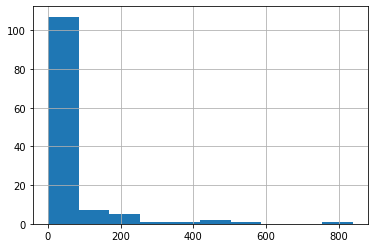

In [15]:
# for some countries postalcode is useless
partner2_df.groupby('country_code').clean_postal_code.apply(lambda x: len(np.unique(x))).hist()

In [20]:
postal2country = partner2_df.groupby('country_code').clean_postal_code.apply(lambda x: len(np.unique(x)))
n2 = partner2_df.loc[partner2_df.country_code.isin(postal2country.loc[postal2country == 1].index), 'clean_postal_code'].shape[0]
partner2_df.loc[partner2_df.country_code.isin(postal2country.loc[postal2country == 1].index), 'clean_postal_code'] = np.repeat([pd.np.nan], n2)

postal2country = partner1_df.groupby('country_code').clean_postal_code.apply(lambda x: len(np.unique(x)))
n1 = partner1_df.loc[partner1_df.country_code.isin(postal2country.loc[postal2country == 1].index), 'clean_postal_code'].shape[0]
partner1_df.loc[partner1_df.country_code.isin(postal2country.loc[postal2country == 1].index), 'clean_postal_code'] = np.repeat([pd.np.nan], n1)

/var/folders/76/4rxszdjj23sftmw56f0_fz5h0000gn/T/ipykernel_28070/2977765283.py:3: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  partner2_df.loc[partner2_df.country_code.isin(postal2country.loc[postal2country == 1].index), 'clean_postal_code'] = np.repeat([pd.np.nan], n2)
/var/folders/76/4rxszdjj23sftmw56f0_fz5h0000gn/T/ipykernel_28070/2977765283.py:7: FutureWarning: The pandas.np module is deprecated and will be removed from pandas in a future version. Import numpy directly instead.
  partner1_df.loc[partner1_df.country_code.isin(postal2country.loc[postal2country == 1].index), 'clean_postal_code'] = np.repeat([pd.np.nan], n1)


<AxesSubplot:>

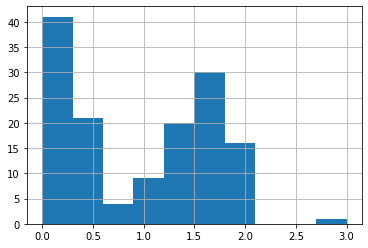

In [30]:
def get_min_postal_dist(r):
    min_dist = 999
    
    perms_p1 = ["".join(p) for p in list(itertools.permutations(r['p1.clean_postal_code']))]+r['p1.clean_postal_code']
    perms_p2 = ["".join(p) for p in list(itertools.permutations(r['p2.clean_postal_code']))]+r['p2.clean_postal_code']
    for p1 in perms_p1:
        for p2 in perms_p2:
            d = damerauLevenshtein(p1.lower(), p2.lower(), similarity=False) / np.min([len(p1), len(p2)])
            if d < min_dist:
                min_dist = d
    return min_dist

example_postal_code_df = examples_df.loc[examples_df['p2.clean_postal_code'] != examples_df['p1.clean_postal_code']].loc[:,['p1.clean_postal_code', 'p2.clean_postal_code']]#.sample(100)

example_postal_code_df['postal_code_dist'] = example_postal_code_df.apply(
    lambda r: get_min_postal_dist(r), axis=1)
example_postal_code_df = example_postal_code_df.loc[example_postal_code_df['postal_code_dist'] != np.inf]
example_postal_code_df.loc[example_postal_code_df["postal_code_dist"] !=999]["postal_code_dist"].hist()

In [218]:
example_postal_code_df.loc[example_postal_code_df["postal_code_dist"] !=999]

,p1.clean_postal_code,p2.clean_postal_code,postal_code_dist
0,[nan],[36113],1.666667
3,[nan],[510420],2.000000
7,"[140, 201]","[140, 200]",0.000000
12,[528000],[528061],0.333333
15,[946],[964],0.333333
...,...,...,...
490,[263761],[11221],1.000000
491,[nan],[300],1.000000
492,[82600],[82000],0.200000
494,[730030],[730000],0.166667


In [31]:
def best_fuzz(s1,s2):
    max_score = 0
    l_s1 = s1.split()
    l_s2 = s2.split()
    perms_s1 = ["".join(l_s1), s1]
    perms_s2 = ["".join(l_s2), s2]
    if s1 in s2 or s2 in s1 and np.min([len(l_s1), len(l_s2)])>1:
        max_score=90        
    for s1_ in perms_s1:
        for s2_ in perms_s2:
            score = fuzz.token_sort_ratio(s1_,s2_)
            if max_score < score:
                max_score = score 
    return (100 - max_score)/100

# doesn't work... will use fuzzywuzzy
def fasttext_cosine_sim(s1, s2, model):
    
    v1 = model.get_sentence_vector(s1).reshape(1, -1)
    v2 = model.get_sentence_vector(s1).reshape(1, -1)
    return 1 - np.round(cosine_similarity(v1,v2)[0][0], 7)


example_hotel_df = examples_df.loc[examples_df['p2.clean_hotel_name'] != examples_df['p1.clean_hotel_name']].loc[:,['p1.clean_hotel_name', 'p2.clean_hotel_name']]#.sample(100)

example_hotel_df['hotel_dist'] = example_hotel_df.apply(
    lambda r: best_fuzz(r['p1.clean_hotel_name'],r['p2.clean_hotel_name']), axis=1)
example_hotel_df.loc[example_hotel_df.hotel_dist > 0]

,p1.clean_hotel_name,p2.clean_hotel_name,hotel_dist
3,7 days inn baiyun yongtai metro 2nd branch,7days inn yongtai subway station 2nd,0.38
5,pension flying sumo,flying sumo surf company,0.41
6,sagala boutique hotel,boutique hotel,0.10
10,inn the city business hotel,inn the city hotel,0.20
11,khumsuk resort,khamsuk resort,0.07
...,...,...,...
484,atrium hotel and suites,atrium hotel jacuzzi suites,0.18
488,hidden paradise by rahi resort,hidden paradise by rahi resorts,0.02
493,green coconut resort ecr,green coconut resort,0.08
494,7 days inn road branch,7days inn road,0.20


In [32]:
example_adderss_df = examples_df.loc[examples_df['p2.clean_address'] != examples_df['p1.clean_address']].loc[:,['p1.clean_address', 'p2.clean_address']]#.sample(100)

example_adderss_df['address_dist'] = example_adderss_df.apply(
    lambda r: best_fuzz(r['p1.clean_address'],r['p2.clean_address']), axis=1)
example_adderss_df.loc[example_adderss_df.address_dist > 0]

,p1.clean_address,p2.clean_address,address_dist
0,jl iskandar muda no 168,jalan iskandar muda no 168 sei asam pasar,0.28
1,171 moo 1 tambol ngiu ampor wiangpapao chiangrai,171 moo 1 tambol pangiu chiangrai,0.23
2,holiday gaura waddo,holiday gaura waddo bardez,0.10
3,building 3 no 116 tongtai,no 3 building no 116 tongtai baiyun,0.17
5,2140 2 machi hama isumi gun,hama 2140 2,0.42
...,...,...,...
492,kirinda sitthulpawwa rottawewa lake,sithulpawwa,0.49
494,no 69 yongchang chengguan,no 69 yongchang,0.10
495,jl dago golf 3 cigadung raya,jl dago golf no 3 cigadung raya,0.04
497,jalan singaraja gilimanuk indonesia,desa sumberkima kecamatan gerokgak kabupaten b...,0.66


In [33]:
# evaluate fuzzywuzzy
import random
pos = random.sample(range(0, examples_df.shape[0]-1), 200)
pos_score = 0
for idx in pos:
    s1 = examples_df.loc[idx, 'p1.clean_hotel_name']
    s2 = examples_df.loc[idx, 'p2.clean_hotel_name']
    pos_score += best_fuzz(s1, s2) #, hotel_model)
pos_score = pos_score/200

neg = random.sample(range(0, examples_df.shape[0]-1), 200)
neg_score = 0
for idx in neg:
    s1 = examples_df.loc[idx,'p1.clean_hotel_name']
    s2 = examples_df['p2.clean_hotel_name'].sample(1).values[0]
    neg_score += best_fuzz(s1, s2) #, hotel_model)
neg_score = neg_score/200

"hotel names", pos_score, neg_score

('hotel names', 0.07995000000000001, 0.6419)

In [34]:
# evaluate fuzzywuzzy
import random
pos = random.sample(range(0, examples_df.shape[0]-1), 200)
pos_score = 0
for idx in pos:
    s1 = examples_df.loc[idx, 'p1.clean_address']
    s2 = examples_df.loc[idx, 'p2.clean_address']
    pos_score += best_fuzz(s1, s2) #, hotel_model)
pos_score = pos_score/200

neg = random.sample(range(0, examples_df.shape[0]-1), 200)
neg_score = 0
for idx in neg:
    s1 = examples_df.loc[idx,'p1.clean_address']
    s2 = examples_df['p2.clean_address'].sample(1).values[0]
    neg_score += best_fuzz(s1, s2) #, hotel_model)
neg_score = neg_score/200

"addresses", pos_score, neg_score

('addresses', 0.14235000000000006, 0.7024499999999998)

In [433]:
# hotel_sents = ". ".join(
#     partner1_df['clean_hotel_name'].values) + ", " + ". ".join(
#      partner2_df['clean_hotel_name'].values) #+ ", " + ". ".join(
# #     examples_df['p1.clean_hotel_name'].values) + ", " + ". ".join(
# #     examples_df['p2.clean_hotel_name'].values) + ", " + ". ".join(
# #     examples_df['p2.clean_address'].values) + ", " + ". ".join(
# #     examples_df['p2.clean_address'].values) + ", " + ". ".join(
# #     partner1_df['clean_address'].values) + ", " + ". ".join(
# #     partner2_df['clean_address'].values)
    
# hotel_sents
# with open('hotel_sents.txt', 'w') as f:
#     f.write(hotel_sents)
    
# hotel_model = fasttext.train_unsupervised('hotel_sents.txt', model='skipgram', lr=0.01, dim=10, epoch=2)

In [576]:
#only very few without country_id so just drop them for now...
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# # one hot encode country_id
# s = pd.Series(all_countries[:10])
# country_dummies = pd.get_dummies(s)
# country_dummies.head()

# from sklearn.preprocessing import OneHotEncoder
# ohe = OneHotEncoder()
# ohe.fit(np.array(all_cities).reshape(-1, 1))
# p1_encoded = ohe.transform(examples_df['p1.all_cities'].values.reshape(-1, 1)).toarray()
# p2_encoded = ohe.transform(examples_df['p2.all_cities'].values.reshape(-1, 1)).toarray()
# # test: examples_df['p1.country_code'][100], ohe.categories_[0][list(p1_encoded[100,:]).index(1)]
# p1_df = pd.DataFrame(p1_encoded, columns=ohe.categories_[0])
# p2_df = pd.DataFrame(p2_encoded, columns=ohe.categories_[0])

In [138]:
p1_df = pd.DataFrame()
p2_df = pd.DataFrame()
final_partner1_df = pd.DataFrame()
final_partner2_df = pd.DataFrame()

list_of_cols_to_use = ['clean_hotel_name', 
                           'clean_address', 
                           'clean_postal_code',
                           'city_name',
                           'country_code']
for col in list_of_cols_to_use:    
    p1_df[col] = examples_df['p1.'+col]
    p2_df[col] = examples_df['p1.'+col]
    final_partner1_df[col] = partner1_df[col]
    final_partner2_df[col] = partner2_df[col]

In [144]:
# generate pos examples
def get_min_postal_dist(s1, s2):
    min_dist = 0.01
    if type(s1) == float or type(s2) == float:
        return min_dist
#     if type(s1) != list:
#         if s1 is pd.np.nan:
#             return min_dist
#         ifs1 = [s1]
#     if type(s2) != list:
#         if s2 is pd.np.nan:
#             return min_dist
#         s2 = [s2]
    perms_p1 = ["".join(str(p)) for p in list(itertools.permutations(list(s1)))] + list(s1)
    perms_p2 = ["".join(str(p)) for p in list(itertools.permutations(list(s2)))] + list(s2)
    for p1 in perms_p1:
        for p2 in perms_p2:
            d = damerauLevenshtein(p1.lower(), p2.lower(), similarity=False) / np.min([len(p1), len(p2)])
            if d < min_dist:
                min_dist = d
    return min_dist

def calc_feature_vec(p1, p2, label):
    features = []
    features.append(
        best_fuzz(p1['clean_hotel_name'], p2['clean_hotel_name'])
    features.append(best_fuzz(p1['clean_address'], p2['clean_address']))
    features.append(best_fuzz(p1['city_name'], p2['city_name']))
    features.append(get_min_postal_dist(p1['clean_postal_code'], p2['clean_postal_code']))
    features.append(label)
    return features
    
    
n = int(p1_df.shape[0]/2)
pos = random.sample(range(0, p1_df.shape[0]-1), n)
pos_features = []
for idx in pos:
    pos_features.append(calc_feature_vec(p1_df.loc[idx,:], p2_df.loc[idx,:], label=1))
    
neg_features = []
for idx in pos:
    new_idx = random.randint(0,p2_df.shape[0]-1)
    neg_features.append(calc_feature_vec(p1_df.loc[idx,:], p2_df.loc[new_idx,:], label=0))
    
all_data = np.array(pos_features + neg_features)

In [141]:
from sklearn.model_selection import train_test_split
X = all_data[:,:-1]
y = all_data[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.50, random_state=42)

# ok time to train - actually stupid since I cleaned the data too much...

it's not surprising the classifier is so good since we saw during sample eval on examples_df that data is seperated well

In [87]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
clf = LogisticRegression(random_state=0).fit(X_train, y_train)
y_pred = clf.predict(X_test)
confusion_matrix(y_test, y_pred)

array([[120,   0],
       [  0, 129]])

# split real data based on country_code

In [142]:
list_final_partner1_df = {code: x for code, x in final_partner1_df.groupby('country_code')}
list_final_partner2_df = {code: x for code, x in final_partner2_df.groupby('country_code')}

# len(np.intersect1d(list(list_final_partner1_df), list(list_final_partner2_df)))/len(list(list_final_partner2_df))

In [145]:
# this really needs to be parallel
import pdb 
from tqdm import tqdm

scores_dict = {}
for code, p1_df in tqdm(list_final_partner1_df.items()):
    p2_df = list_final_partner2_df[code]
   # try:       
    for r1_idx, r1 in p1_df.iterrows():
        if r1_idx in scores_dict.keys():
            print(r1_idx)
        scores_dict[r1_idx] = {}
        for r2_idx, r2 in p2_df.iterrows(): 
            s = 1 - np.mean(calc_feature_vec(r1, r2, -1)[:-1])
#             f = calc_feature_vec(r1, r2, -1)[:-1]
#             if f[1] == 0 or f[2] == 0:
#                 s = 1
#             else:
#                 s = 1 - np.mean(f)
            scores_dict[r1_idx][r2_idx] = s
#     except Exception as e:
#         print(code, e)
#         pdb.set_trace()

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 125/125 [40:05<00:00, 19.24s/it]


In [154]:
# import pickle
# with open('scores_dict1.pkl', 'wb') as handle:
#     pickle.dump(scores_dict, handle)

with open('scores_dict.pkl', 'rb') as handle:
    scores_dict = pickle.load(handle)

In [147]:
def secondmax(arr):
    sublist = [x for x in arr if x < max(arr)]
    return np.max(sublist), np.argmax(sublist)

In [195]:
mapping_dict = {}
used_p1 = set()
used_p2 = set()
count1 = []
count2 = []
c = 0
for key, val in scores_dict.items():
    f = 0
    v_scores = []
    for v in val.values():
        v_scores.append(v[0][1])
    p2 = list(val)[np.argmax(v_scores)]
    
    p2_max_score = np.max(v_scores)
#     if p2_max_score < 0.5:
#         print(key, p2, p2_max_score)
#         c+= 1
    if key in used_p1:
        f=1
        count1.append(p1)
    if p2 in used_p2:
        f=1
        count2.append(p2)
    if f:
        # Im just going to skip the problematic ones because of lack of time
        continue
    mapping_dict[p2] = (key, p2_max_score)
    used_p1.add(key)
    used_p2.add(p2)

In [237]:
col1, col2 = [], []
for key, (val, score) in mapping_dict.items():
    # this should be experimented more but works ok from manual experiments
    if score > 0.3:
        if partner1_df.loc[val, 'country_code'] != partner2_df.loc[key, 'country_code']:
            print("country_code sanity failed")
            break
        col1.append(partner1_df.loc[val, 'key']) 
        col2.append(partner2_df.loc[key, 'key'])

df = pd.DataFrame({'P1.key': col1, 'P2.key': col2})
df.shape
#df.to_csv("mapping.csv")

(9120, 2)

In [255]:
# sanity checks
i = 7577
pd.concat([partner1_df.loc[partner1_df.key == df["P1.key"][i]], partner2_df.loc[partner2_df.key == df["P2.key"][i]]]) 

,key,hotel_name,city_name,country_code,hotel_address,star_rating,postal_code,country_name,clean_postal_code,clean_address,clean_hotel_name
3533,342FA6E48173B8396CAE2BE4CDEF862F,feng chia enjoy,taichung,TW,"no.23, ln. 101, zhishan rd.",0.0,40745,taiwan (province of china),[40745],no 23 ln 101 zhishan,feng chia enjoy
9611,37CE703ED195AA8C71C91ED8EC17C7CE,feng chia enjoy,xitun,TW,"no. 23, lane 101, zhishan road",1.0,407,taiwan (province of china),[407],no 23 lane 101 zhishan,feng chia enjoy
